このノートブックは以下のノートブックを参考にして作成されました。

この場を借りてノートブックを共有してくださったことに感謝したいと思います。

https://www.kaggle.com/code/utm529fg/eng-tutorial-3-beam-search

また、以下のノートブックを利用してid4以外の答えを作成しています。ありがとうございます。

https://www.kaggle.com/code/jazivxt/diminutive-effort-tpu

This notebook was created with reference to the following notebook:

https://www.kaggle.com/code/utm529fg/eng-tutorial-3-beam-search

I would like to take this opportunity to express my gratitude to the author for sharing their notebook.

Additionally, I used the following notebook to generate answers other than id4. Thank you very much.

https://www.kaggle.com/code/jazivxt/diminutive-effort-tpu

このノートブックはGPU環境下で実行に3時間程度かかります。実行される際は注意してください。

元ノートブックからの変更点として、ビーム幅を可変にしています。

これにより、重要な局面で多くの情報を残すことができます。

This notebook takes approximately 3 hours to run in a GPU environment. Please be cautious when executing it.

As a modification from the original notebook, the beam width has been made adjustable.

This allows for retaining more information during critical stages.

In [1]:
print("Yes")

Yes


# 3-2. Implementation 実装

In [2]:
"""Evaluation metric for Santa 2024."""

import gc
import os
from math import exp
from collections import Counter
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import transformers
import torch

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
PAD_TOKEN_LABEL_ID = torch.nn.CrossEntropyLoss().ignore_index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    model_path: str = '/kaggle/input/gemma-2/transformers/gemma-2-9b/2',
    load_in_8bit: bool = False,
    clear_mem: bool = False,
) -> float:
    """
    Calculates the mean perplexity of submitted text permutations compared to an original text.

    Parameters
    ----------
    solution : DataFrame
        DataFrame containing the original text in a column named 'text'.
        Includes a row ID column specified by `row_id_column_name`.

    submission : DataFrame
        DataFrame containing the permuted text in a column named 'text'.
        Must have the same row IDs as the solution.
        Includes a row ID column specified by `row_id_column_name`.

    row_id_column_name : str
        Name of the column containing row IDs.
        Ensures aligned comparison between solution and submission.

    model_path : str, default='/kaggle/input/gemma-2/transformers/gemma-2-9b/2'
        Path to the serialized LLM.

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    clear_mem : bool, default=False
        Clear GPU memory after scoring by clearing the CUDA cache.
        Useful for testing.

    Returns
    -------
    float
        The mean perplexity score. Lower is better.

    Raises
    ------
    ParticipantVisibleError
        If the submission format is invalid or submitted strings are not valid permutations.

    Examples
    --------
    >>> import pandas as pd
    >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'text': ["this is a normal english sentence", "the quick brown fox jumps over the lazy dog"]
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'text': ["sentence english normal a is this", "lazy the over jumps fox brown quick the dog"]
    ... })
    >>> score(solution, submission, 'id', model_path=model_path, clear_mem=True) > 0
    True
    """
    # Check that each submitted string is a permutation of the solution string
    sol_counts = solution.loc[:, 'text'].str.split().apply(Counter)
    sub_counts = submission.loc[:, 'text'].str.split().apply(Counter)
    invalid_mask = sol_counts != sub_counts
    if invalid_mask.any():
        raise ParticipantVisibleError(
            'At least one submitted string is not a valid permutation of the solution string.'
        )

    # Calculate perplexity for the submitted strings
    sub_strings = [
        ' '.join(s.split()) for s in submission['text'].tolist()
    ]  # Split and rejoin to normalize whitespace
    scorer = PerplexityCalculator(
        model_path=model_path,
        load_in_8bit=load_in_8bit,
    )  # Initialize the perplexity calculator with a pre-trained model
    perplexities = scorer.get_perplexity(
        sub_strings
    )  # Calculate perplexity for each submitted string

    if clear_mem:
        # Just move on if it fails. Not essential if we have the score.
        try:
            scorer.clear_gpu_memory()
        except:
            print('GPU memory clearing failed.')

    return float(np.mean(perplexities))


class PerplexityCalculator:
    """
    Calculates perplexity of text using a pre-trained language model.

    Adapted from https://github.com/asahi417/lmppl/blob/main/lmppl/ppl_recurrent_lm.py

    Parameters
    ----------
    model_path : str
        Path to the pre-trained language model

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    device_map : str, default="auto"
        Device mapping for the model.
    """

    def __init__(
        self,
        model_path: str,
        load_in_8bit: bool = False,
        device_map: str = 'auto',
    ):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)
        # Configure model loading based on quantization setting and device availability
        if load_in_8bit:
            if DEVICE.type != 'cuda':
                raise ValueError('8-bit quantization requires CUDA device')
            quantization_config = transformers.BitsAndBytesConfig(load_in_8bit=True)
            self.model = transformers.AutoModelForCausalLM.from_pretrained(
                model_path,
                quantization_config=quantization_config,
                device_map=device_map,
            )
        else:
            self.model = transformers.AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype=torch.float16 if DEVICE.type == 'cuda' else torch.float32,
                device_map=device_map,
            )

        self.loss_fct = torch.nn.CrossEntropyLoss(reduction='none')

        self.model.eval()

    def get_perplexity(
        self, input_texts: Union[str, List[str]], debug=False
    ) -> Union[float, List[float]]:
        """
        Calculates the perplexity of given texts.

        Parameters
        ----------
        input_texts : str or list of str
            A single string or a list of strings.

        batch_size : int, default=None
            Batch size for processing. Defaults to the number of input texts.

        debug : bool, default=False
            Print debugging information.

        Returns
        -------
        float or list of float
            A single perplexity value if input is a single string,
            or a list of perplexity values if input is a list of strings.

        Examples
        --------
        >>> import pandas as pd
        >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
        >>> scorer = PerplexityCalculator(model_path=model_path)

        >>> submission = pd.DataFrame({
        ...     'id': [0, 1, 2],
        ...     'text': ["this is a normal english sentence", "thsi is a slihgtly misspelled zr4g sentense", "the quick brown fox jumps over the lazy dog"]
        ... })
        >>> perplexities = scorer.get_perplexity(submission["text"].tolist())
        >>> perplexities[0] < perplexities[1]
        True
        >>> perplexities[2] < perplexities[0]
        True

        >>> perplexities = scorer.get_perplexity(["this is a sentence", "another sentence"])
        >>> all(p > 0 for p in perplexities)
        True

        >>> scorer.clear_gpu_memory()
        """
        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts

        loss_list = []
        with torch.no_grad():
            # Process each sequence independently
            for text in input_texts:
                # Explicitly add sequence boundary tokens to the text
                text_with_special = f"{self.tokenizer.bos_token}{text}{self.tokenizer.eos_token}"

                # Tokenize
                model_inputs = self.tokenizer(
                    text_with_special,
                    return_tensors='pt',
                    add_special_tokens=False,
                )

                if 'token_type_ids' in model_inputs:
                    model_inputs.pop('token_type_ids')

                model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

                # Get model output
                output = self.model(**model_inputs, use_cache=False)
                logits = output['logits']

                # Shift logits and labels for calculating loss
                shift_logits = logits[..., :-1, :].contiguous()  # Drop last prediction
                shift_labels = model_inputs['input_ids'][..., 1:].contiguous()  # Drop first input

                # Calculate token-wise loss
                loss = self.loss_fct(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1)
                )

                # Calculate average loss
                sequence_loss = loss.sum() / len(loss)
                loss_list.append(sequence_loss.cpu().item())

                # Debug output
                if debug:
                    print(f"\nProcessing: '{text}'")
                    print(f"With special tokens: '{text_with_special}'")
                    print(f"Input tokens: {model_inputs['input_ids'][0].tolist()}")
                    print(f"Target tokens: {shift_labels[0].tolist()}")
                    print(f"Input decoded: {self.tokenizer.decode(model_inputs['input_ids'][0])}")
                    print(f"Target decoded: {self.tokenizer.decode(shift_labels[0])}")
                    print(f"Individual losses: {loss.tolist()}")
                    print(f"Average loss: {sequence_loss.item():.4f}")

        ppl = [exp(i) for i in loss_list]

        if debug:
            print("\nFinal perplexities:")
            for text, perp in zip(input_texts, ppl):
                print(f"Text: '{text}'")
                print(f"Perplexity: {perp:.2f}")

        return ppl[0] if single_input else ppl

    def clear_gpu_memory(self) -> None:
        """Clears GPU memory by deleting references and emptying caches."""
        if not torch.cuda.is_available():
            return

        # Delete model and tokenizer if they exist
        if hasattr(self, 'model'):
            del self.model
        if hasattr(self, 'tokenizer'):
            del self.tokenizer

        # Run garbage collection
        gc.collect()

        # Clear CUDA cache and reset memory stats
        with DEVICE:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            torch.cuda.reset_peak_memory_stats()

In [3]:
sample_submission = pd.read_csv('/kaggle/input/santa-2024/sample_submission.csv')

In [4]:
# initialize scorer
scorer = PerplexityCalculator('/kaggle/input/gemma-2/transformers/gemma-2-9b/2')

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
import random
import time
class BeamSearch():
    def __init__(self, beam_width):
        self.beam_width = beam_width

    def _make_candidates_adding_word(self, intermediate_solution, words):
        '''Make candidate text so that word duplication does not occur'''
        candidates = []
        not_used_words = words.copy()
        for used_word in intermediate_solution.split():
            not_used_words.remove(used_word)
        
        candidates += [(intermediate_solution + ' ' + word).lstrip() for word in not_used_words]
        candidates += [(word + ' ' + intermediate_solution).rstrip() for word in not_used_words]

        candidates = list(set(candidates)) # drop duplicate
        
        return candidates
    def solve(self, text):
        words = text.split()
        intermediate_solutions = ['']
        eval_cnt = 0

        while len(intermediate_solutions[0].split()) < len(words):
            start_time = time.time()
            candidates = []
            for intermediate_solution in intermediate_solutions:
                candidates += self._make_candidates_adding_word(intermediate_solution, words)
            
            # 重複を排除
            candidates = list(set(candidates))
            
            scores = scorer.get_perplexity(candidates)
            eval_cnt += len(scores)
            
            # スコアと候補をペアにする
            scored_candidates = list(zip(scores, candidates))
            
            # スコアでソート（低い順）
            scored_candidates.sort(key=lambda x: x[0])
            
            # ビーム幅に基づいて上位k個を選択、重複を避ける
            new_intermediate_solutions = []
            seen = set()
            for score, candidate in scored_candidates:
                if candidate not in seen:
                    new_intermediate_solutions.append(candidate)
                    seen.add(candidate)
                if score < 1.1*scored_candidates[0][0] and len(new_intermediate_solutions) < 7:
                    continue
                if len(new_intermediate_solutions) >= self.beam_width:
                    break
            
            intermediate_solutions = new_intermediate_solutions
            print(f"score, intermediate_solutions:{min(scorer.get_perplexity(intermediate_solutions))}, {intermediate_solutions}")
            print(f"remain_time:{len(new_intermediate_solutions[0].split())}/{len(words)}, {(len(words)-len(new_intermediate_solutions[0].split()))*(time.time()-start_time)}\n")

        # 最終的なベストスコアとソリューションを取得
        final_scores = scorer.get_perplexity(intermediate_solutions)
        best_idx = np.argmin(final_scores)
        best_score = final_scores[best_idx]
        best_solution = intermediate_solutions[best_idx]

        return best_score, best_solution, eval_cnt

In [6]:
params = {
    'beam_width': 2,
}
optimizer = BeamSearch(**params)

In [7]:
sample_submission.loc[0]["text"]

'advent chimney elf family fireplace gingerbread mistletoe ornament reindeer scrooge'

In [8]:
import time
start_time = time.time()
from tqdm import tqdm
scores = []
solutions = []
eval_cnts = []
# for text in tqdm(sample_submission['text']):
#text = sample_submission.loc[4]["text"]
#score, solution, eval_cnt = optimizer.solve(text)
#scores.append(score)
#solutions.append(solution)
#eval_cnts.append(eval_cnt)

#print(scores)
#print(solutions)
#print(eval_cnts)
#print(f"execute_time:{time.time()-start_time}")

In [9]:
solutions = ['hohoho season merry have you cookie chocolate candy milk eggnog fruitcake peppermint candle snowglobe fireplace wreath poinsettia wish dream hope believe peace joy wonder night star angel greeting card wrapping paper bow kaggle workshop toy doll game puzzle the of and to in that from not it with as we']

In [10]:
most_best_text = "from and as have in not it of that the to we with you bow angel believe candle candy card chocolate cookie doll dream eggnog fireplace fruitcake game greeting hohoho hope joy kaggle merry milk night peace peppermint poinsettia puzzle season snowglobe star toy wreath wish workshop wonder wrapping paper"


In [11]:
import math
class SimulatedAnnealing:
    def __init__(self, start_temp, end_temp, max_iterations, random_state, alpha):
        self.start_temp = start_temp
        self.end_temp = end_temp
        self.max_iterations = max_iterations
        random.seed(random_state)
        self.alpha = alpha  # 指数減少率

    def _generate_neighbor(self, solution):
        """
        
        近傍解を生成（ランダムな2単語を入れ替え）
        """
        r = random.choice(range(5))
        if r == 0:
            # Generate a neighborhood solution by swapping two random words.
            neighbor = solution.copy()
            i, j = random.sample(range(len(neighbor)), 2)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            return neighbor
        elif r==1:
            # 
            shift = solution.copy()
            extract, insert = random.sample(range(len(shift) - 1), 2)
            shift_words = shift[extract:extract+1]
            shift = shift[:extract] + shift[extract+1:]
            shift = shift[:insert] + shift_words + shift[insert:]
            return shift
        elif r == 2:
            neighbor = solution.copy()
            if len(neighbor) < 2:
                return neighbor
            start = random.randint(0, len(neighbor) - 2)
            end = random.randint(start + 1, len(neighbor) - 1)
            neighbor[start:end+1] = reversed(neighbor[start:end+1])
            return neighbor
        else:
            #  block_size = random.choice(range(2, 5))
            #  block_size = 2
            block_size = r-1
            neighbor = solution.copy()
            if len(neighbor) < block_size + 1:
                return neighbor
            start = random.randint(0, len(neighbor) - block_size)
            block = neighbor[start:start + block_size]
            insert_pos = random.randint(0, len(neighbor) - block_size)
            # ブロックを削除
            del neighbor[start:start + block_size]
            # 挿入位置にブロックを挿入
            neighbor = neighbor[:insert_pos] + block + neighbor[insert_pos:]
            return neighbor

    def _acceptance_probability(self, current_energy, new_energy, temperature):
        """
        Calculate the probability of accepting a new solution.
        新しい解を受け入れる確率を計算
        """
        if new_energy < current_energy:
            return 1.0
        return exp((current_energy - new_energy) / temperature)

    def _lower_temperature(self, temperature, iteration):
        """
        温度を指数関数的に減少させる。
        """
        # 指数関数的減少
        new_temperature = self.start_temp * (self.alpha ** iteration)
        
        return new_temperature
    def solve(self, text):
        current_solution = text.split()
        current_energy = scorer.get_perplexity(' '.join(current_solution))

        best_solution = current_solution.copy()
        best_energy = current_energy

        temperature = self.start_temp
        
        log_energies = [current_energy]
        start_time = time.time()
        spend_minute = 0
        for iteration in range(self.max_iterations):
            # generate neighbor
            new_solution = self._generate_neighbor(current_solution)
            new_energy = scorer.get_perplexity(' '.join(new_solution))

            # calculation of acceptance probability
            acceptance = self._acceptance_probability(
                current_energy, new_energy, temperature
            )
            
            # update current solution
            if acceptance > random.random():
                current_solution = new_solution
                current_energy = new_energy
                
            # update best solution
            if new_energy < best_energy:
                best_solution = new_solution.copy()
                best_energy = new_energy
                print(f"best_score:{best_energy}")

            # lower the temperature
            temperature = self._lower_temperature(temperature, iteration)
            # print("temperature:", temperature)

            # log
            log_energies.append(current_energy)
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            if time.time()-start_time-60*spend_minute > 60:
                spend_minute += 1
                print(f"{current_time} progress:{iteration/self.max_iterations}, current_score:{current_energy}, temperature:{temperature}, best_score:{best_energy}")
                
            if temperature <= self.end_temp:
                print("最低温度に到達しました。終了します。")
                break
                
                
        print(f"execution time:{time.time()-start_time}")
        return ' '.join(best_solution), best_energy, log_energies

In [12]:
sa_params = {
    'start_temp': 20,          # 最初の温度
    'end_temp': 0.01,             # 最後の温度　線形に下げていく
    'max_iterations': 50000,  # 反復回数100000回で4時間程度か
    'random_state': 42,
    "alpha":0.9999
}
sa_optimizer = SimulatedAnnealing(**sa_params)

In [13]:
solution, score_2, log_scores = sa_optimizer.solve(solutions[0])


2024-12-20 03:33:06 progress:0.00956, current_score:604.4173444206025, temperature:19.066443086085854, best_score:100.18409172815403
2024-12-20 03:34:06 progress:0.01904, current_score:594.3689687901692, temperature:18.183735000796503, best_score:100.18409172815403
2024-12-20 03:35:06 progress:0.02852, current_score:752.1543036974308, temperature:17.341893141069892, best_score:100.18409172815403
2024-12-20 03:36:06 progress:0.03798, current_score:766.5226898566787, temperature:16.540679614864455, best_score:100.18409172815403
2024-12-20 03:37:06 progress:0.04746, current_score:631.0618695760331, temperature:15.774905339804379, best_score:100.18409172815403
2024-12-20 03:38:06 progress:0.05696, current_score:654.0191640784636, temperature:15.043079214975759, best_score:100.18409172815403
2024-12-20 03:39:06 progress:0.06644, current_score:616.4927215293324, temperature:14.34663847924159, best_score:100.18409172815403
2024-12-20 03:40:06 progress:0.07592, current_score:526.98287093524, t

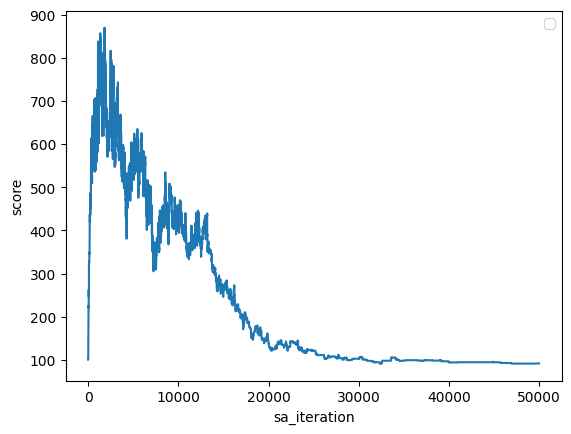

SA Score: 90.81087515997825


In [14]:
import matplotlib.pyplot as plt
plt.plot(log_scores)

# plt.title(f'id = {4}, num of word = {len(text.split())}')
plt.xlabel('sa_iteration')
plt.ylabel('score')
plt.legend()
plt.show()

print(f'SA Score: {score_2}')


In [15]:
print(scorer.get_perplexity(solution), solution)

90.81087515997825 the of to and as in not it have from we with you that candle night season wonder wish hope dream believe joy peace merry hohoho chocolate cookie milk eggnog fruitcake peppermint candy toy doll game puzzle snowglobe fireplace angel star wreath poinsettia greeting card wrapping paper bow kaggle workshop


In [16]:
print(scorer.get_perplexity(most_best_text))

94.97277748044158


In [17]:
scorer.get_perplexity(' '.join(most_best_text.split()[:50]))

94.97277748044158

In [18]:
p = '/kaggle/input/santa-2024/sample_submission.csv'
df = pd.read_csv(p)

In [19]:
t = """reindeer mistletoe elf gingerbread family advent scrooge chimney fireplace ornament
reindeer sleep walk the night and drive mistletoe scrooge laugh chimney jump elf bake gingerbread family give advent fireplace ornament
magi yuletide cheer grinch carol holiday holly jingle naughty nice nutcracker polar beard ornament stocking chimney sleigh workshop gifts decorations
sleigh of the magi yuletide cheer is unwrap gifts and eat cheer holiday decorations holly jingle relax carol sing chimney visit grinch naughty nice polar beard workshop nutcracker ornament stocking
from and as have in not it of that the to we with you bow angel believe candle candy card chocolate cookie doll dream eggnog fireplace fruitcake game greeting hohoho hope joy kaggle merry milk night peace peppermint poinsettia puzzle season snowglobe star toy wreath wish workshop wonder wrapping paper
from and and as and have the in is it of not that the to we with you advent card angel bake beard believe bow candy candle carol cheer cheer chocolate chimney cookie decorations doll dream drive eat eggnog family fireplace fireplace chimney fruitcake game give gifts gingerbread greeting grinch holiday holly hohoho hope jingle jump joy kaggle laugh magi merry milk mistletoe naughty nice night night elf nutcracker ornament ornament of the wrapping paper peace peppermint polar poinsettia puzzle reindeer relax scrooge season sing sleigh sleep snowglobe star stocking toy unwrap visit walk wish wonder workshop workshop wreath yuletide"""

df['text'] = t.split('\n')
df.loc[4, "text"] = solution
df['score'] = df['text'].map(lambda x: scorer.get_perplexity(x))
df.to_csv("submission.csv", index=False)
print(np.mean(df['score']))
df['score']

254.34767964302148


0    468.961335
1    421.728839
2    302.640572
3    207.300886
4     90.810875
5     34.643570
Name: score, dtype: float64

In [20]:
df

,id,text,score
0,0,reindeer mistletoe elf gingerbread family adve...,468.961335
1,1,reindeer sleep walk the night and drive mistle...,421.728839
2,2,magi yuletide cheer grinch carol holiday holly...,302.640572
3,3,sleigh of the magi yuletide cheer is unwrap gi...,207.300886
4,4,the of to and as in not it have from we with y...,90.810875
5,5,from and and as and have the in is it of not t...,34.643570


In [21]:
10**20*0.9999**20000

1.3532174948276005e+19